# Zadanie nr 5 - Metryki w przestrzeni napisów

In [1]:
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt
from math import inf
from collections import Counter

## 1. Metryki

<i>Zaimplementuj przynajmniej 3 metryki spośród wymienionych: cosinusowa, LCS, DICE, euklidesowa.</i>

x, y - napisy/listy, których odległość szukamy. oznaczenie odpowiada temu w slajdach z laboratorium

* LCS

In [2]:
def lcs(x, y):
    common = [[0 for _ in range(len(y)+1)] for _ in range(len(x)+1)]
    max_lcs = 0

    for i in range(1, len(x) + 1):
        for j in range(1, len(y)+1):
            common[i][j] = common[i-1][j-1] + 1 if x[i-1] == y[j-1] else 0
            max_lcs = max(max_lcs, common[i][j])

    return 1 - max_lcs/max(len(x), len(y))

#### ngramy

In [3]:
def ngrams(x, n):
    ngrams = [x[i:i+n] for i in range(len(x)-n+1)]
    return Counter(ngrams)

* Sorensena-Dice'a

In [4]:
def dice(x, y, n=2):
    n = min([n, len(x), len(y)])
    ngrams_x, ngrams_y = set(ngrams(x, n).keys()), set(ngrams(y, n).keys())
    return 1 - 2*len(ngrams_x & ngrams_y)/(len(ngrams_x)+len(ngrams_y))

* euklidesowa

In [5]:
def euclides(x, y, n=2):
    n = min([n, len(x), len(y)])
    ngrams_x, ngrams_y = ngrams(x, n), ngrams(y, n)

    keys = set(ngrams_x.keys()) | set(ngrams_y.keys())
    dist = sum((ngrams_x.get(key, 0) - ngrams_y.get(key, 0))**2 for key in keys) 
    len_x = sum(count**2 for key, count in ngrams_x.items())
    len_y = sum(count**2 for key, count in ngrams_y.items())

    return (dist/(len_x + len_y))**0.5

* cosinusowa

In [6]:
def cosine(x, y, n=2):
    n = min([n, len(x), len(y)])
    ngrams_x, ngrams_y = ngrams(x, n), ngrams(y, n)
    dot = lambda n_x, n_y: sum(n_x[key]*n_y[key] for key in n_x.keys() & n_y.keys())
    return 1 - dot(ngrams_x, ngrams_y)/(dot(ngrams_x, ngrams_x)
                                        *dot(ngrams_y, ngrams_y))**0.5

* Levenshteina

In [7]:
def levenshtein(x, y):
    edit = [[max(i, j) for i in range(len(y) + 1)]
            for j in range(len(x) + 1)]

    def delta(char_a, char_b): 
        return 0 if char_a == char_b else 1
    
    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            edit[i][j] = min(edit[i-1][j] + 1, edit[i][j-1] + 1,
                       edit[i-1][j-1] + delta(x[i-1], y[j-1]))

    return edit[len(x)][len(y)]/max(len(x), len(y))

#### test metryk

Poniżej znajduję wartości poszczególnych metryk w trzech przypadkach dobranych tekstów. 

Wartości dla poszczególnych metryk często różnią się między sobą, jednak funkcje zostały zaimplementowane w taki sposób, aby wartości te były mniej więcej porównywalne. Dlatego w przypadku metryki Levenshteina odległość edycyjną dzielę przez maksymalną długość obydwu tekstów, natomiast odległość euklidesową znormalizowałem przez pierwiastek sumy kwadratów długości wektorów otrzymanych z liczby wystąpień poszczególnych ngramów. Dzięki temu dla każdej z metryk spełniony jest fakt, iż przyjmuje ona wartość 0 dla tożsamych napisów oraz wartość 1 dla zupełnie różniących się (w rozumieniu danej metryki).

* podobne napisy

In [8]:
x = 'BCDF'
y = 'ABCDEF'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('cosine: ', cosine(x, y))
print('levenshtein: ', levenshtein(x, y))

lcs:  0.5
dice:  0.5
euclides:  0.7071067811865476
cosine:  0.4836022205056778
levenshtein:  0.3333333333333333


* napisy zupełnie różne

In [9]:
x = 'BCDF'
y = 'A'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('cosine: ', cosine(x, y))
print('levenshtein: ', levenshtein(x, y))

lcs:  1.0
dice:  1.0
euclides:  1.0
cosine:  1.0
levenshtein:  1.0


* napisy tożsame

In [10]:
x = 'BCDF'
y = 'BCDF'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('cosine: ', cosine(x, y))
print('levenshtein: ', levenshtein(x, y))

lcs:  0.0
dice:  0.0
euclides:  0.0
cosine:  0.0
levenshtein:  0.0


## 2. Sposoby oceny jakości klasteryzacji

<i>Zaimplementuj przynajmniej 2 sposoby oceny jakości klasteryzacji (np. indeks Daviesa-Bouldina).</i>

* indeks Daviesa-Bouldina

In [11]:
def average_distance_in_cluster(cluster, metric):
    sum_ = 0
    n = len(cluster)
    if n == 1: return 0
    
    for i, text_i in enumerate(cluster):
        for text_j in cluster[i+1:]:
                sum_ += metric(text_i, text_j)
                
    return sum_ /(n*(n-1)/2)

def cluster_distance(cluster_a, cluster_b, metric):
    sum_ = 0
    
    return sum(metric(text_a, text_b) 
               for text_a in cluster_a 
               for text_b in cluster_b)/(len(cluster_a)
                                         *len(cluster_b))

In [12]:
def davies_bouldin(clusters, metric):
    index = 0
    sigmas = [average_distance_in_cluster(cluster, metric) for cluster in clusters]
    
    for i, cluster_i in enumerate(clusters):
        max_ = 0
        for j, cluster_j in enumerate(clusters):
            if i == j: continue
            max_ = max(max_, (sigmas[i] + sigmas[j])/cluster_distance(cluster_i, cluster_j, metric))
        index += max_
        
    return index/len(clusters)        

* indeks Dunna

In [13]:
def cluster_size(cluster, metric):
    if len(cluster) == 1: return 0
    return max(metric(text_i, text_j) for i, text_i in enumerate(cluster) for text_j in cluster[i+1:])

In [14]:
def dunn(clusters, metric):
    min_dist = min(cluster_distance(cluster_a, cluster_b, metric)
                   for i, cluster_a in enumerate(clusters)
                   for cluster_b in clusters[i+1:])
    max_size = max(cluster_size(cluster, metric)
                    for cluster in clusters)
    
    if max_size == 0: 
        return inf
    
    return min_dist/max_size

#### test indeksów

* odległe klastry

In [15]:
clusters = [["AB", "CD"], ["xy", "wt"]]

In [16]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  2.0
	          dunn index:  1.0


* bliskie klastry

In [17]:
clusters = [["AB", "CD"], ["ABc", "CDe"]]

In [18]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  3.0938363213560542
	          dunn index:  0.6464466094067263


* odległe elementy w klastrze

In [19]:
clusters = [["ABC", "XYZ"], ["abc", "xyz"]]

In [20]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  2.0
	          dunn index:  1.0


* bliskie elementy w klastrze

In [21]:
clusters = [["ABCE", "ABCD"], ["abce", "abce"]]

In [22]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  0.33333333333333337
	          dunn index:  2.9999999999999996


Z powyższych testów możemy zauważyć, iż im większa wartość indeksu Dunna tym lepsza jakość klasteryzacji, natomiast w przypadku indeksu Daviesa-Bouldina lepsza jest mniejsza wartość.

Klasteryzacja jest uznawana za lepszą, gdy elementy w poszczególnych klastrach są blisko siebie, a za to klastry daleko od siebie nawzajem.

## 3. Stoplista

<i> Stwórz stoplistę najczęściej występujących słów. </i>

Stoplistę tworzę dzieląc linijki na słowa, a następnie znajdując najczęściej powtarzające się słowa we wszystkich linijkach.

In [23]:
def get_stop_words(lines, min_count):
    word_count = Counter(word for line in lines for word in line.replace('.', ' ').split(' '))
    word_count = list(word_count.items())
    word_count.sort(key=lambda x: x[1], reverse=True)
    return [word for word, count in word_count if count >= min_count]

In [24]:
def remove_common(lines, min_count):
    stop_list = get_stop_words(lines, min_count)
    return [' '.join([word for word in line.split(' ') if word not in stop_list]) for line in lines], stop_list

## 4. Klasteryzacja

<i> Wykonaj klasteryzację zawartości załączonego pliku (lines.txt) przy użyciu metryk zaimplementowanych w pkt. 1. i metryki Levenshteina. Każda linia to adres pocztowy firmy, różne sposoby zapisu tego samego adresu powinny się znaleźć w jednym klastrze. </i>

Do klasteryzacji używam funkcji DBSCAN z biblioteki sklearn.cluster.

In [25]:
def cluster(lines, metric, eps=0.86):
    distances = [[metric(line_a, line_b) for line_a in lines] for line_b in lines]
    clustering = sklearn.cluster.DBSCAN(eps=eps, min_samples=1).fit(distances)
    return clustering.labels_

## 5. Testy

<i> Porównaj jakość wyników sposobami zaimplementowanymi w pkt. 2. </i>

#### odczytanie danych testowych

Z uwagi na duży czas działania programu, korzystam tylko ze 100 linijek. Dzięki temu najwolniejsze metody (lcs, levenshtein) nie działają dłużej niż parę minut.

In [26]:
def get_example_lines(num):
    with open('lines.txt', 'r') as file:
        lines = list(file)
        
    lines = lines[:num]

    with open('clusters.txt', 'r') as file:
        clusters = list(file)
    
    correct_clustering = []
    cluster_num = 0
    
    for line in lines:
        cluster = 0
        for cluster_line in clusters:
            if cluster_line[0] == '#':
                cluster += 1
            elif cluster_line == line:
                correct_clustering.append(cluster)
                break
    
    return lines, np.array(correct_clustering)

In [27]:
lines, correct_labels = get_example_lines(100)

#### testy krok po kroku

* klasteryzacja - znalezienie listy z indeksami klastrów poszczególnych linii danych:

In [28]:
labels = cluster(lines, cosine)

In [29]:
print(labels)

[ 0  1  2  2  3  4  5  6  7  8  9 10 11 11 11 11 11 11 11 12 12 13 14 15
 16 17 18 19 19 20 21 22 23 23 24 25 26 27 17 28 29 30 31 32 33 34 35 36
 37 37 17 38 38 38 39 40 39 40 41 41 41 41 41 41 11 11 11 42 42 42 43 44
 45 46 47 48 49 50 51 15 52 52 17 53 53 54 17 55  2 17 56 57 17 58 59 58
 60 60 60 60]


Dla porównania wypisuję poprawne przyporządkowanie linijek na podstawie załączonego pliku (wartości mogą się różnić, ważna jest równość etykiet poszczególnych elementów).

In [30]:
def renumber_labels(labels):
    seen = {}
    current = 0
    new_labels = []
    for label in labels:
        if label in seen:
            new_labels.append(seen[label])
        else:
            new_labels.append(current)
            seen[label] = current
            current += 1
    
    return np.array(new_labels)

In [31]:
print(renumber_labels(correct_labels))

[ 0  1  2  2  3  4  5  6  7  8  9 10 11 11 11 11 11 11 11 12 12 13 14 14
 15 16 17 18 18 19 20 21 22 22 23 24 25 26 27 28 29 29 30 31 32 33 34 35
 36 36 37 38 38 38 39 39 39 39 40 40 40 40 40 40 41 41 41 42 42 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56 56 57 58 59  2 60 61 62 63 64 63 64
 65 65 65 65]


* podzielenie linijek na klastry na podstawie etykiet

In [32]:
def get_clusters_from_labels(lines, labels):
    clusters = {}
    for i, label in enumerate(labels):
        clusters[label] = clusters.get(label, []) + [lines[i]]
        
    return list(clusters.values())

In [33]:
clusters = get_clusters_from_labels(lines, labels)

In [34]:
def print_clustering(clusters):
    for cluster in clusters:
        print('##########')
        for line in cluster:
            print(line)

In [35]:
print_clustering(clusters)

##########
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA

##########
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611

##########
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 WARSZAWA UL PRZECLAWSKA 5 NIP:113-01-17-669

##########
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND

##########
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939

##########
"2TIGERS GROUP LIMITED"  ROOM 504 JINSHAZHOU SHANGSHUI ROAD,  GUANGZHOU 510160

##########
"ALDETRANS" LLC, 105066, MOSCOW, RUSSIA, TOKMAKOV LANE, 11. TEL:+7(495)641-03-89

##########
"A-LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA,MOSCOW

* ocena klasteryzacji, znalezienie wartości obydwu indeksów

dla znalezionych klastrów:

In [36]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  0.7477794160582196
	          dunn index:  0.7400810281179782


dla poprawnych klastrów:

In [37]:
correct_clusters = get_clusters_from_labels(lines, correct_labels)
print('\tdavies-bouldin index: ', davies_bouldin(correct_clusters, cosine))
print('\t          dunn index: ', dunn(correct_clusters, cosine))

	davies-bouldin index:  0.9600618831700587
	          dunn index:  0.4148461875933154


Poprawna klasteryzacja ma gorsze wartości indeksów niż uzyskana. Może to oznaczać, iż użyta metryka nie najlepiej opisuje podobieństwo powiązanych linijek.

#### wersja z zastosowaniem stoplisty 

* usunięcie słów ze stoplisty

In [38]:
lines_stop, common_words = remove_common(lines, 8)
print('removed words: ', common_words)

removed words:  ['', 'STR', 'LTD', 'TEL', 'ST', 'RUSSIA', ',', 'LLC', 'SAINT-PETERSBURG,', 'PETERSBURG,', '812', '+7', 'O', 'STREET,', 'COMPANY', 'LIT', 'GAPSALSKAYA', 'RUSSIA,', '5', 'CO', 'TEL:', 'RUSSIAN']


In [39]:
def show_differences(lines, lines_stop):
    for line, line_stop in zip(lines, lines_stop):
        if line != line_stop:
            print(line)
            print(line_stop, '\n')

* klasteryzacja

In [40]:
labels = cluster(lines_stop, cosine)

In [41]:
print(labels)

[ 0  1  2  2  3  4  5  6  7  8  9 10 11 11 11 11 11 11 11 12 12 13 14 15
 16 17 18 19 19 20 21 22 23 23 24 25 26 27 27 28 29 30 31 32 33 34 35 36
 37 37 38 39 39 39 40 41 40 41 42 42 42 42 42 42 43 11 11 44 44 44 45 46
 47 48 49 50 51 52 53 54 55 55 56 57 57 58 59 60  2 61 62 63 64 65 66 65
 67 67 67 67]


* podzielenie linijek na klastry w postaci zbiorów

In [42]:
clusters = get_clusters_from_labels(lines_stop, labels)

In [43]:
def get_clusters_from_labels(lines, labels):
    clusters = {}
    for i, label in enumerate(labels):
        clusters[label] = clusters.get(label, []) + [lines[i]]
        
    return list(clusters.values())

In [44]:
print_clustering(clusters)

##########
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA

##########
''PA INTERIOR'' BOLSHAYA LUBYANKA 16/4 MOSCOW, 101000, INN/KPP 7704550148//770801001 495-984-8611

##########
''SSONTEX'' Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 WARSZAWA UL PRZECLAWSKA NIP:113-01-17-669

##########
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4 02-285 WARSZAWA POLAND

##########
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939

##########
"2TIGERS GROUP LIMITED" ROOM 504 JINSHAZHOU SHANGSHUI ROAD, GUANGZHOU 510160

##########
"ALDETRANS" LLC, 105066, MOSCOW, TOKMAKOV LANE, 11. TEL:+7(495)641-03-89

##########
"A-LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA,MOSCOW 123308,RUSSIA T: +7(495)784-7961

##

* ocena klasteryzacji, znalezienie wartości obydwu indeksów

In [45]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  0.4823673943365842
	          dunn index:  0.5312993284234436


W tym przypadku, nie możemy jednoznacznie stwierdzić, czy usunięcie niektórych słów poprawiło jakość klasteryzacji.

#### porównanie wyników dla różnych metryk

In [46]:
def test(lines, metric):
    print(metric.__name__)
    labels = cluster(lines, metric)
    clusters = get_clusters_from_labels(lines, labels)
    
    davies_index = davies_bouldin(clusters, metric)
    dunn_index = dunn(clusters, metric)
    print('\tdavies-bouldin index: ', davies_index)
    print('\t          dunn index: ', dunn_index)
    
    return davies_index, dunn_index

In [47]:
def compare_metrics(lines, metrics):
    davies_indices = []
    dunn_indices = []
    
    for metric in metrics:
        davies, dunn = test(lines, metric)
        davies_indices.append(davies)
        dunn_indices.append(dunn)
        
    print('\n\n---with stoplist---')
    lines_stop, _ = remove_common(lines, 8)
    for metric in metrics:
        davies, dunn = test(lines_stop, metric)
        davies_indices.append(davies)
        dunn_indices.append(dunn)
    
    return davies_indices, dunn_indices

In [48]:
metrics = [dice, cosine, euclides, levenshtein, lcs]

In [49]:
davies_indices, dunn_indices = compare_metrics(lines, metrics)

dice
	davies-bouldin index:  0.7667990839471491
	          dunn index:  0.7613930140572199
cosine
	davies-bouldin index:  0.7477794160582196
	          dunn index:  0.7400810281179782
euclides
	davies-bouldin index:  0.5997238554017978
	          dunn index:  0.9426037036635696
levenshtein
	davies-bouldin index:  0.6107574836919204
	          dunn index:  0.857097238804556
lcs
	davies-bouldin index:  0.6480094789187549
	          dunn index:  0.8795031055900621


---with stoplist---
dice
	davies-bouldin index:  0.5832760255640013
	          dunn index:  0.8548269230769229
cosine
	davies-bouldin index:  0.4823673943365842
	          dunn index:  0.5312993284234436
euclides
	davies-bouldin index:  0.632246911690487
	          dunn index:  0.8688212214193677
levenshtein
	davies-bouldin index:  0.6251224709456794
	          dunn index:  0.8809980082085949
lcs
	davies-bouldin index:  0.7106617779346485
	          dunn index:  0.8041425525434055


* wzorcowa klasteryzacja z pliku

In [50]:
def get_indices_correct_clustering(lines, correct_labels, metrics):
    correct_clusters = get_clusters_from_labels(lines, correct_labels)
    correct_davies = []
    correct_dunn = []
    
    for metric in metrics:
        davies_index = davies_bouldin(correct_clusters, metric)
        dunn_index = dunn(correct_clusters, metric)
        print(metric.__name__)
        print('\tdavies-bouldin index: ', davies_index)
        print('\t          dunn index: ', dunn_index)
        correct_davies.append(davies_index)
        correct_dunn.append(dunn_index)
    
    return correct_davies, correct_dunn

In [51]:
correct_davies, correct_dunn = get_indices_correct_clustering(lines, correct_labels, metrics)

dice
	davies-bouldin index:  0.8892659116999325
	          dunn index:  0.5504428023309978
cosine
	davies-bouldin index:  0.9600618831700587
	          dunn index:  0.4148461875933154
euclides
	davies-bouldin index:  1.0630485855555134
	          dunn index:  0.6972860692469977
levenshtein
	davies-bouldin index:  0.947804783049698
	          dunn index:  0.6948018528049409
lcs
	davies-bouldin index:  1.0905759199429839
	          dunn index:  0.695609756097561


* wykres

In [58]:
def plot_comparison(metrics, davies_indices, dunn_indices, correct_davies, correct_dunn):
    fig, ax = plt.subplots(1, 2, figsize=(15,8))
    
    metric_names = list(map(lambda x: x.__name__, metrics))
    
    x = np.arange(len(metrics))
    width = 0.3
    
    ax[0].bar(x-width, davies_indices[:len(metrics)], color='coral', width=width, label='dbscam clustering')
    ax[0].bar(x, davies_indices[len(metrics):], color='orange', width=width, label='dbscan with stoplist')
    ax[0].bar(x+width, correct_davies, color='goldenrod', width=width, label='correct labels from the file')
    
    ax[1].bar(x-width, dunn_indices[:len(metrics)], color='royalblue', width=width, label='dbscan clustering')
    ax[1].bar(x, dunn_indices[len(metrics):], color='cornflowerblue', width=width, label='dbscan with stoplist')
    ax[1].bar(x+width, correct_dunn, color='cadetblue', width=width, label='correct labels from the file')
    
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(metric_names)
    
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(metric_names)
    
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Davies-Bouldin')
    ax[1].set_title('Dunn')
    
    plt.show()

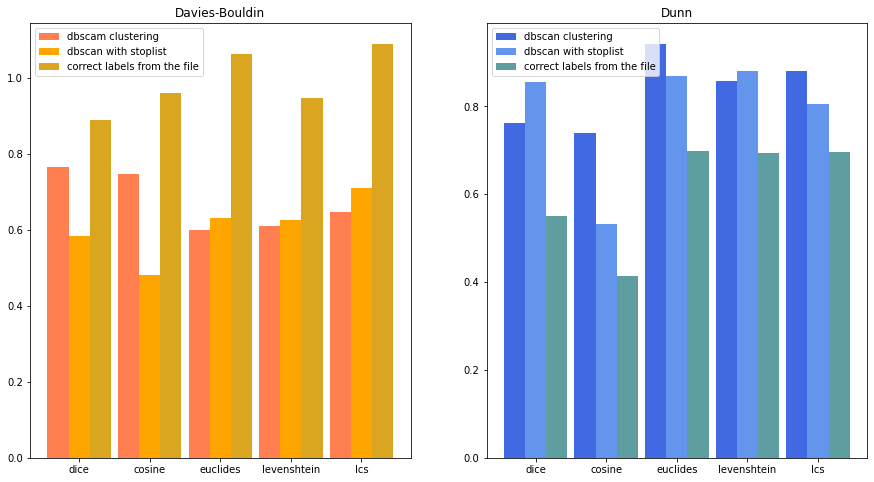

In [59]:
plot_comparison(metrics, davies_indices, dunn_indices, correct_davies, correct_dunn)

Z powyższej zależności możemy zauważyć, iż zastosowanie stoplisty zmieniło w pewnym stopniu jakość klasteryzacji, jednak nie zawsze na lepsze, zależy od konretnego przypadku.

Porównując wartości indeksów dla klasteryzacji otrzymanej algorytmem DBSCAN a klasteryzacją z pliku, zawsze lepiej wypada klasteryzacja znaleziona algorytmicznie. Wynika to z faktu, że żadna metryka nie przedstawia w pełni rzeczywistego podobieństwa tekstów. Dlatego dla danej metryki znaleziona klasteryzacja procedurą biblioteczną jest możliwie najbardziej optymalna, zakładając skuteczność algorytmu. 

Z wykresu można by chcieć wnioskować, iż do klasteryzacji najlepiej sprawdziły się metryki LCS, euklidesowa i przede wszystkim Levenshteina, jednak obliczając indeksy dla tych metryk korzystamy z odległości wyznaczonych tymże metodami, co nie pozwala jednoznacznie ich porównać. Indeksy dobrze sprawdzają się do porównania różnych algorytmów klasteryzacji.

<i>Czy masz jakiś pomysł na poprawę jakości klasteryzacji w tym zadaniu? </i>

* Przeprowadzenie preprocessingu pliku wejściowego. Usunięcię niepotrzebnych białych znaków, cudzysłowów, kropek itd.
* Lepsze dobranie parametrów modelu. W powyższych rozważaniach dla każdej metryki zostały użyte te same parametry modelu. Lepsze wyniki uzyskalibyśmy analizując wartości w macierzy odległości i wybierając odpowiednią wartość chociażby parametru eps. Moglibyśmy także przetestować wyniki dla zmieniających się parametrów i wybrać najlepszy rezultat.

## Wnioski

- Skuteczność klasteryzacji zależy od doboru metryki, jak również dobranych do niej parametrów.

- Skuteczność tę można zwiększyć stosując stoplistę najczęściej występujących elementów, jednak nie w każdym przypadku ma to sens, zależy to od rodzaju danych z jakimi mamy do czynienia

- Stosowanie zagadnienia klasteryzacji dla tekstów jest problematyczne. Nie dysponujemy łatwą do znalezienia lokalizacją centroidy klastra czy rozmiaru klastra, wymagana jest spora złożoność czasowa lub odpowiednie heurystyczne podejście, które mogłoby przybliżyć te wartości.

M. Hawryluk 21.05.2021